<a href="https://colab.research.google.com/github/AishlyManglani/Deep-Learning_-CMPE258/blob/main/computer%20vision/Zero_shot_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 1. Install & Import Libraries
# ============================================
!pip install -q transformers pillow

import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from PIL import Image
import requests

In [7]:


# ============================================
# 2. Load CLIP Model
# ============================================
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

# ============================================
# 3. Load Sample Images
# ============================================
# Load images from local files
urls = [
    "/content/bird.jpg",  # bird
    "/content/car.jpg",  # car
    "/content/coffee.jpg",  # coffee
]

# Use Image.open directly for local files
images = [Image.open(url) for url in urls]

# ============================================
# 4. Define Zero-shot Classes
# ============================================
zero_shot_labels = ["a photo of a bird", "a photo of a car", "a photo of a coffee"]

# ============================================
# 5. Encode Images and Text
# ============================================
inputs = processor(text=zero_shot_labels, images=images, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the similarity score
probs = logits_per_image.softmax(dim=1)




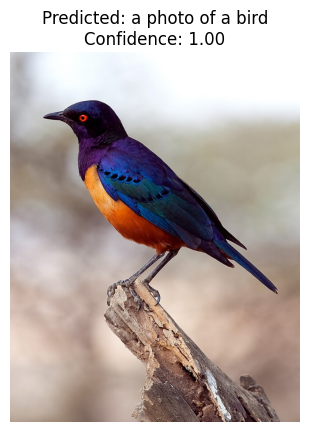

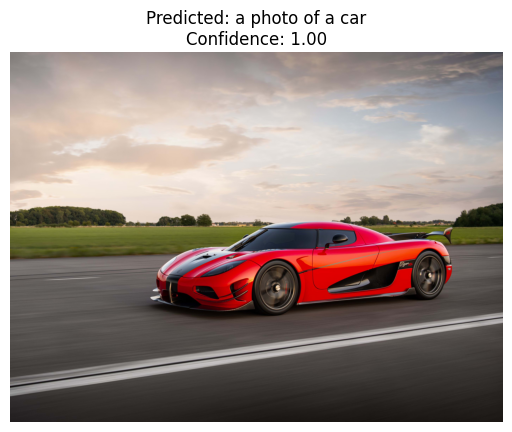

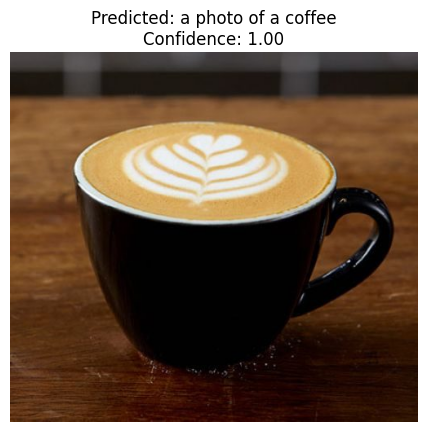

In [8]:
# ============================================
# 6. Visualize Results
# ============================================
for i, image in enumerate(images):
    plt.imshow(image)
    plt.axis("off")
    pred = zero_shot_labels[probs[i].argmax()]
    plt.title(f"Predicted: {pred}\nConfidence: {probs[i].max().item():.2f}")
    plt.show()

In [9]:
# ============================================
# 1. Install & Import Libraries
# ============================================
!pip install -q tensorflow tensorflow_hub tensorflow_datasets

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [11]:


# ============================================
# 2. Load Flowers Dataset
# ============================================
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True,
)

NUM_CLASSES = ds_info.features['label'].num_classes
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ============================================
# 3. Load Pretrained BiT Model
# ============================================
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"

bit_feature_extractor = hub.KerasLayer(bit_model_url, trainable=False)






In [18]:
# ============================================
# 4. Build Feature Extraction Model
# ============================================
# Correct Functional API way (with Lambda wrapper)
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(lambda x: bit_feature_extractor(x))(inputs)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile and train
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1045s 11s/step - accuracy: 0.7099 - loss: 1.6105 - val_accuracy: 0.9428 - val_loss: 0.1787
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1028s 11s/step - accuracy: 0.9531 - loss: 0.1560 - val_accuracy: 0.9564 - val_loss: 0.1319
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1038s 11s/step - accuracy: 0.9729 - loss: 0.0766 - val_accuracy: 0.9619 - val_loss: 0.1265
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1012s 11s/step - accuracy: 0.9848 - loss: 0.0452 - val_accuracy: 0.9537 - val_loss: 0.1505
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1036s 11s/step - accuracy: 0.9889 - loss: 0.0505 - val_accuracy: 0.9591 - val_loss: 0.1272


NameError: name 'initial_epochs' is not defined

In [22]:
# ============================================
# 5. Fine-tune Model Correctly (Corrected)
# ============================================

# Make the original bit_feature_extractor trainable
bit_feature_extractor.trainable = True  # << Correct name here!

# Recompile with smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = history.epoch[-1] + 1 + fine_tune_epochs  # after previous epochs

# Continue training (fine-tuning phase)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1
)

Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1020s 11s/step - accuracy: 0.9971 - loss: 0.0174 - val_accuracy: 0.9646 - val_loss: 0.1224
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1056s 11s/step - accuracy: 0.9963 - loss: 0.0215 - val_accuracy: 0.9646 - val_loss: 0.1224
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1011s 11s/step - accuracy: 0.9973 - loss: 0.0170 - val_accuracy: 0.9646 - val_loss: 0.1234
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1045s 11s/step - accuracy: 0.9959 - loss: 0.0174 - val_accuracy: 0.9646 - val_loss: 0.1237
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 979s 11s/step - accuracy: 0.9967 - loss: 0.0151 - val_accuracy: 0.9619 - val_loss: 0.1242


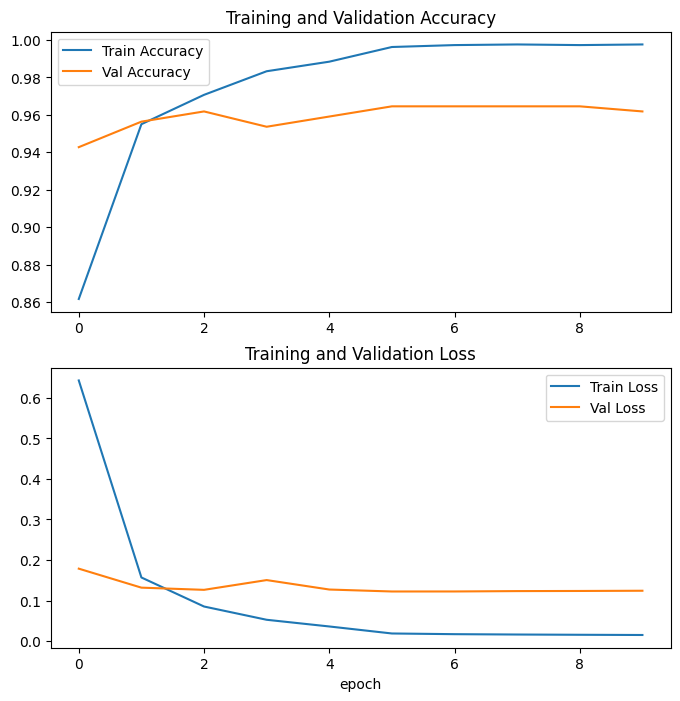

In [23]:
# ============================================
# 7. Visualize Training Results
# ============================================
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:

# ============================================
# 8. Evaluate on Test Set
# ============================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 109s 9s/step - accuracy: 0.9686 - loss: 0.1299
Test Accuracy: 0.98
